In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


import sys
sys.path.insert(0,'../GSHEWaveform/')
sys.path.insert(0,'../')

import forecast as fc

# Import data

We read the file and remove points where there is a nan or a large value of beta (almost certainly numerical)

**Notes**
* I suspect that extreme values of beta happend because the trajectories get swapped: they're Dt/eps^2 ~ 10/1e-3^2
* this happens when both beta1, beta2 are extreme. These are the majority of cases (ca 150). There are cases in which only one of the betas is extreme, which can't be explained in this way. These are fewer (ca 8)
* trajectories are not ordered, sometimes the first trajectory has positive parity, sometimes negative parity. **easy fix:** keep finite $\epsilon$ time delays
* What points have a nan?

In [16]:
# keep_keys = ['a_kerr', 'r_obs', 'r_src', 'Δt', 'β', 'βLR', 'θ_obs', 'θ_src', 'μ', 'ϕ_obs', 'ϕ_src', 'ϵ0'] #'Xeps', 'Xgeo', 


data = h5py.File("../../data/GSHE_runs/random_trajectories_2023_12_03_15_56_50.h5", "r")

print(data['Trajectory_1']['β'][0])
print(data['Trajectory_1']['α'][0])
print(data['Trajectory_1']['μ'])

[[1.05824831 1.05937625]
 [1.05836202 1.06557815]
 [1.00099699 1.05755793]]
[[1.99985344 1.98992743]
 [2.00017435 2.00625559]
 [2.99477554 2.99917529]]
<HDF5 dataset "μ": shape (2,), type "<f8">


## Import, discard "bad" trajectories

In [3]:
#single file

data = h5py.File("../data/trajectories/random_trajectories_2023_10_14_19_22_04.h5", "r")

dat_base = {'θ_obs': [], 
           'θ_src' : [], 
           'ϕ_obs' : [], 
           'ϕ_src' : [], 
           'Δt' : [], 
           'μ' : [], 
           'β' : [], 
#            'βLR' : [], 
#            'ϵ0' : []
           }

for t, d in data.items():
    for k, r in dat_base.items():
        val = d[k][()] if d[k].shape == () else d[k][:]  # Handle both scalar and array dat_basea
        r.append(val)


for k,r in dat_base.items():
    dat_base[k] = np.array(r)

In [17]:
import numpy as np
import h5py
import glob

#all the files

# Initialize the base data structure
dat_base = {
    'θ_obs': [],
    'θ_src': [],
    'ϕ_obs': [],
    'ϕ_src': [],
    'Δt': [],
    'μ': [],
    'β': [],
    'βLR': []
}

# List all .h5 files
h5_files = glob.glob("../data/trajectories/*.h5")

# Loop through each .h5 file
for h5_file in h5_files:
    with h5py.File(h5_file, "r") as data:
        for t, d in data.items():
            for k, r in dat_base.items():
                val = d[k][()] if d[k].shape == () else d[k][:]
                r.append(val)

# Convert lists to numpy arrays
for k, r in dat_base.items():
    dat_base[k] = np.array(r)


In [5]:

dat = {'θ_obs': [], 
        'θ_src' : [], 
        'ϕ_obs' : [], 
        'ϕ_src' : [], 
        'Δt' : [], 
        'μ' : [], 
        'β' : [], 
#         'βLR' : [], 
#       'ϵ0' : []
           }

# flip = (dat_base['Δt']<0)
    
for k in ['μ','β','βLR']:
    val = np.where(np.expand_dims(dat_base['Δt']>0,1),dat_base[k],np.flip(dat_base[k],1))  # Handle both scalar and array data
    dat[k] = val

for k in ['θ_obs', 'θ_src','ϕ_obs','ϕ_src', 'Δt']:
    dat[k] = dat_base[k]
    
dat['Δt'] = np.abs(dat['Δt'])

for k,r in dat.items():
    dat[k] = np.array(r)

In [6]:
#apply a series of cuts to the 

bt_cut = 1e3
bt_min = 1e-15
dt_cut = 1e10

pts = (np.isfinite(dat['Δt']) & np.isfinite(dat['μ'][:,0]) & np.isfinite(dat['μ'][:,1]))
pts *= ((dat['ϕ_obs']<2*np.pi)*(dat['ϕ_src']<2*np.pi))
pts *= ((dat['Δt']>1/dt_cut)*(dat['Δt']<dt_cut))

for betas in [dat['β'][:,0],dat['β'][:,1],dat['βLR'][:,0],dat['βLR'][:,1]]:
    pts *= ((np.abs(betas)<bt_cut)*(np.abs(betas)>bt_min))
    
print('removing large β leaves', np.sum(pts), 'out of',len(pts))


removing large β leaves 1660 out of 4155


In [7]:
# ((dat['ϕ_obs']<2*np.pi)*(dat['ϕ_src']<2*np.pi)).shape
((dat['ϕ_obs']>2*np.pi)*(dat['ϕ_src']>2*np.pi)).sum()

0

In [8]:
dat['ϕ_obs'][pts].max()
dat['Δt'][pts].min()
dat['μ'][pts].max()
np.abs(dat['β'][pts]).min()
np.abs(dat['βLR'][pts]).max()

165.0773384653803

In [9]:

#NEED TO CHECK!

print('N both betas large',np.sum((np.abs(dat_base['β'][:,0])>1e3) & (np.abs(dat_base['β'][:,1])>1e3)))
print('N only one beta large', np.sum(((np.abs(dat_base['β'][:,0])>1e3) & (np.abs(dat_base['β'][:,1])<1e3)) | ((np.abs(dat_base['β'][:,0])<1e3) & (np.abs(dat_base['β'][:,1])>1e3))))
print('total bad points', np.sum(pts))
print('need to check!')

N both betas large 1669
N only one beta large 509
total bad points 1660
need to check!


### bad vs good trajectories

deflection angle $\alpha$, such that $\cos(\alpha) = - \sum_i \hat x_{i,\rm src}\hat x_{i,\rm obs}$ (**check**).

**Note: that's deflection from SOURCE, not for TRAJECTORY!**

In [70]:
cosA = -((np.cos(dat['ϕ_obs'])*np.cos(dat['ϕ_src']) + np.sin(dat['ϕ_obs'])*np.sin(dat['ϕ_src'])
         )*np.sin(dat['θ_obs'])*np.sin(dat['θ_src'])
         +np.cos(dat['θ_obs'])*np.cos(dat['θ_src']))

alpha=np.arccos(cosA)

Text(0.5, 0, '$\\cos(\\alpha)$ (deflection angle)')

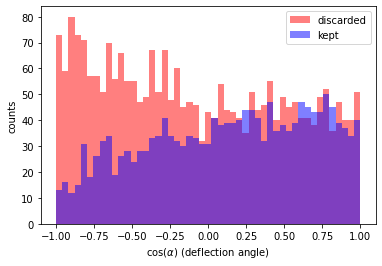

In [69]:
plt.hist(cosA[~pts],np.linspace(-1,1),color='r',alpha=.5,label='discarded')
plt.hist(cosA[pts],np.linspace(-1,1),color='b',alpha=.5,label='kept')

plt.legend()

plt.ylabel(r'counts')
plt.xlabel(r'$\cos(\alpha)$ (deflection angle)')

Text(0, 0.5, '$\\theta_{o}-\\theta_{s}$')

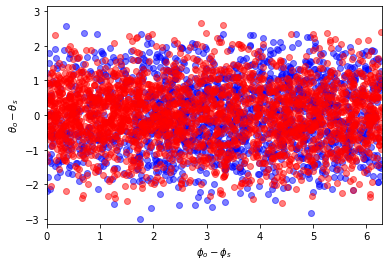

In [92]:
X = dat['ϕ_obs']-dat['ϕ_src']
Y = dat['θ_obs']-dat['θ_src']

plt.scatter(X[pts],Y[pts],c='b',alpha=.5)
plt.scatter(X[~pts],Y[~pts],c='r',alpha=.5)

plt.xlim(0,2*np.pi)
plt.ylim(-np.pi,np.pi)

plt.xlabel(r'$\phi_{o}-\phi_{s}$')
plt.ylabel(r'$\theta_{o}-\theta_{s}$')

Text(0.5, 0, '$\\phi_{o}-\\phi_{s}$')

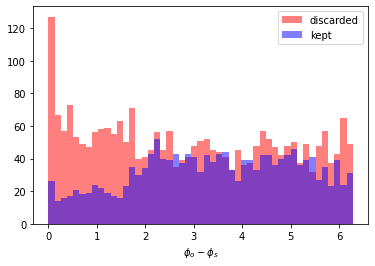

In [93]:
X = dat['ϕ_obs']-dat['ϕ_src']
# Y = dat['θ_obs']-dat['θ_src']

plt.hist(X[~pts],np.linspace(0,2*np.pi),color='r',alpha=.5,label='discarded')
plt.hist(X[pts],np.linspace(0,2*np.pi),color='b',alpha=.5,label='kept')

plt.legend()

plt.xlabel(r'$\phi_{o}-\phi_{s}$')
# plt.ylabel(r'$\theta_{o}-\theta_{s}$')

Text(0.5, 0, '$\\theta_{o}-\\theta_{s}$')

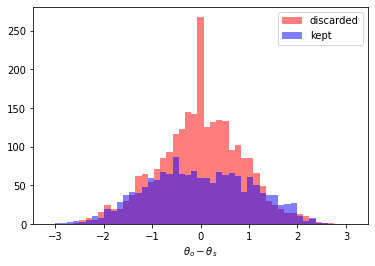

In [94]:
# X = dat['ϕ_obs']-dat['ϕ_src']
Y = dat['θ_obs']-dat['θ_src']

plt.hist(Y[~pts],np.linspace(-np.pi,np.pi),color='r',alpha=.5,label='discarded')
plt.hist(Y[pts],np.linspace(-np.pi,np.pi),color='b',alpha=.5,label='kept')

# plt.xlim(-np.pi,np.pi)
plt.legend()

plt.xlabel(r'$\theta_{o}-\theta_{s}$')

### Try to fix the values (TO DO)

In [613]:
#do a normal and re-arrange

test = {'θ_obs': [], 
           'θ_src' : [], 
           'ϕ_obs' : [], 
           'ϕ_src' : [], 
           'Δt' : [], 
           'μ' : [], 
           'β' : [], 
           'βLR' : [], 
           'Xgeo' :[],
           'Xeps' : [],
           'ϵ0' : []
           }

for t, d in data.items():
    for k, r in test.items():
        val = d[k][()] if d[k].shape == () else d[k][:]  # Handle both scalar and array dat_basea
        r.append(val)
        
for k,r in test.items():
    test[k] = np.array(r)

In [615]:
from copy import deepcopy
def fix_quantities(results):
    test = deepcopy(results)
    for i,dt in enumerate(test['Δt']):
        eps = test['ϵ0'][i]
        #geometry, values, trajectory
        Xgeo = test['Xgeo'][i]
        #geometry, values, spin, trajectory
        Xeps = test['Xeps'][i]

        #reverse the order according to GO
        if dt >0:
            Xgeo0= Xgeo[:,0]
            Xgeo1 = Xgeo[:,1]
        else: #swap
            Xgeo0= Xgeo[:,1]
            Xgeo1 = Xgeo[:,0]
            test['μ'][i] = test['μ'][i][::-1]
            test['Δt'] = -test['Δt']
    #         print(test['μ'][i])

        #identify GSHE & GO trajectories based on initial direction
        d00 = np.sum(Xgeo0[:2]-Xeps[:2,0,0])**2
        d01 = np.sum(Xgeo0[:2]-Xeps[:2,0,1])**2
        d11 = np.sum(Xgeo1[:2]-Xeps[:2,0,1])**2

        #re-compute quantities
        if d01 > max(d00,d11):
            print(i,'keep')
            #swap
            Xeps0 = Xeps[:,:,1]
            Xeps1 = Xeps[:,:,0]
    #         test['Xeps'][i] = np.concatenate(Xeps1,Xeps0)
        else:
            print(i,'swap',d00,d01)
            Xeps0 = Xeps[:,:,0]
            Xeps1 = Xeps[:,:,1]
        print(test['β'][i],end=' ')
        test['β'][i] = np.array([Xeps0[2,0]-Xgeo0[2],Xeps1[2,0]-Xgeo1[2]])/eps**2
        print(test['β'][i])
        test['βLR'][i] = np.array([Xeps0[2,0]-Xeps0[2,1],Xeps1[2,0]-Xeps1[2,1]])/eps**3
    
    #second stage, remove points where soemthing is a nan.
    nans = np.any(np.isnan(test['β']),axis=1) & np.any(np.isnan(test['μ']),axis=1)
#     print(nans.sum())
    
    for k,r in test.items():
        test[k] = r[~nans] 
    return test  
    
dat = fix_quantities(test)
dat['β']

0 keep
[-0.02351364 -0.5764132 ] [ 21793911.89745658 -21793911.29752974]
1 keep
[-0.13230995  0.29335371] [ 8633775.20957169 -8633775.37061545]
2 swap 2.0658866208812427e-09 1.0340441927062405
[-2.11986375e-02  1.68094126e+07] [ 2.11986375e-02 -1.68094126e+07]
3 keep
[-0.15464472  0.25523293] [ 8196776.74972918 -8196776.85031739]
4 keep
[-4.55058924e-03  1.23155149e+07] [ 23607608.96705506 -35923123.81655261]
5 keep
[-0.0221153  -0.34146688] [ 21186284.75622227 -21186284.39264009]
6 swap 11.151490486633762 2.5188755951909655e-08
[-5438106.44320892  5438106.63918931] [ 5438106.44320892 -5438106.63918931]
7 swap 1.698127481833206 1.4241825823983343e-08
[-13846750.83570756  13846750.93174006] [ 13846750.83570756 -13846750.93174006]
8 swap nan nan
[-0.00424722         nan] [              nan 27811386.71685151]
9 keep
[-0.00384994  1.38704682] [ 29653543.1321317  -29653544.51532858]
10 keep
[-2.41890845e-02  1.19894811e+07] [ 21157091.5190886  -33146572.62627086]
11 swap 1.0904059141315311e

[ 14775533.61490978 -14775533.52294665] [ 14775533.52294665 -14775533.61490978]
340 keep
[-1.25798678e-02  1.29106719e+07] [ 21047524.7889794  -33958196.66085931]
341 keep
[ 14742583.49492329 -25874354.52852045] [ 25874354.52852045 -14742583.49492329]
342 keep
[-0.06973417  0.20010717] [ 12867658.7570851  -12867658.88745809]
343 swap 11.991384982411885 3.447175839931384e-10
[-1.15635463e+01 -5.46410917e-04] [ 30118856.82790994 -30118845.26381722]
344 swap 7.696857904049422 1.7290117128101738e-09
[-2.60207208 -0.00842057] [ 23541757.70265336 -23541755.09216071]
345 keep
[ 17897674.55761673 -17897674.7292551 ] [ 17897674.7292551  -17897674.55761673]
346 keep
[-0.01026264 -0.96649283] [ 25072124.10208323 -25072123.12532776]
347 swap 6.568337510636516 7.22509842783345e-07
[ 3.08810698e+07 -1.67009219e-01] [-19181417.65476461 -11699652.01585534]
348 swap 6.092550762200421 5.1746873969584085e-11
[-23844501.14344183  23844497.34367586] [ 23844501.14344183 -23844497.34367586]
349 swap 21.92831

array([[ 2.17939119e+07, -2.17939113e+07],
       [ 8.63377521e+06, -8.63377537e+06],
       [ 2.11986375e-02, -1.68094126e+07],
       [ 8.19677675e+06, -8.19677685e+06],
       [ 2.36076090e+07, -3.59231238e+07],
       [ 2.11862848e+07, -2.11862844e+07],
       [ 5.43810644e+06, -5.43810664e+06],
       [ 1.38467508e+07, -1.38467509e+07],
       [ 2.96535431e+07, -2.96535445e+07],
       [ 2.11570915e+07, -3.31465726e+07],
       [ 1.56535052e-02, -1.19857219e+07],
       [ 2.04593150e+07, -2.04593147e+07],
       [ 1.73293973e+07, -1.73293972e+07],
       [ 4.87215219e+06, -4.87215234e+06],
       [ 2.14887514e+07, -2.14887497e+07],
       [ 1.96059730e+07, -1.96059727e+07],
       [ 2.44999004e+07, -2.44998998e+07],
       [ 2.43303888e+07, -2.43303801e+07],
       [ 1.93221976e+07, -1.93221973e+07],
       [ 2.19965899e+07, -2.19965892e+07],
       [ 6.67873130e+06, -6.67873143e+06],
       [-2.51275623e-03,  7.78643073e+06],
       [ 2.27718618e+07, -2.27718611e+07],
       [ 2.

In [599]:
nans = np.any(np.isnan(test['β']),axis=1)* np.any(np.isnan(test['μ']),axis=1)
print(test['β'][~nans])
nans

[[ 2.17939119e+07 -2.17939113e+07]
 [ 8.63377521e+06 -8.63377537e+06]
 [ 2.11986375e-02 -1.68094126e+07]
 [ 8.19677675e+06 -8.19677685e+06]
 [ 2.36076090e+07 -3.59231238e+07]
 [ 2.11862848e+07 -2.11862844e+07]
 [ 5.43810644e+06 -5.43810664e+06]
 [ 1.38467508e+07 -1.38467509e+07]
 [ 2.96535431e+07 -2.96535445e+07]
 [ 2.11570915e+07 -3.31465726e+07]
 [ 1.56535052e-02 -1.19857219e+07]
 [ 2.04593150e+07 -2.04593147e+07]
 [ 1.73293973e+07 -1.73293972e+07]
 [ 4.87215219e+06 -4.87215234e+06]
 [ 2.14887514e+07 -2.14887497e+07]
 [ 1.96059730e+07 -1.96059727e+07]
 [ 2.44999004e+07 -2.44998998e+07]
 [ 2.43303888e+07 -2.43303801e+07]
 [ 1.93221976e+07 -1.93221973e+07]
 [ 2.19965899e+07 -2.19965892e+07]
 [ 6.67873130e+06 -6.67873143e+06]
 [-2.51275623e-03  7.78643073e+06]
 [ 2.27718618e+07 -2.27718611e+07]
 [ 2.14373582e+07 -2.14373580e+07]
 [ 4.43634795e+06 -4.43634807e+06]
 [ 5.52605428e-03  9.60896010e+06]
 [ 3.70121906e+07 -3.70121918e+07]
 [ 1.37978320e+07 -1.37978319e+07]
 [ 1.63347241e+07 -1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [514]:
# [init_angle_1, init_angle_2, arrival_time, grav_redshift, optimizer_minimum, nloops, phi_killing, initial_attempt, magnification]

#geometry, values, trajectory
test['Xgeo'][7,:2,:],test['Xeps'][7,:2,0,:]
# #geometry, values, spin, trajectory
# test['Xeps'][0,:,0,0]

(array([[1.0111399 , 2.19617198],
        [4.57037488, 2.08161283]]),
 array([[2.19674811, 1.01123909],
        [2.08164447, 4.57039503]]))

In [511]:
#TRY TO GET THE VALUES FROM XGEO, XEPS

# [init_angle_1, init_angle_2, arrival_time, grav_redshift, optimizer_minimum, nloops, phi_killing, initial_attempt, magnification]

#geometry, values, trajectory
test['Xgeo'][0,:,0]
#geometry, values, spin, trajectory
test['Xeps'][0,:,0,0]
for i in [2,4,6,7]: # range(len(test['Δt'])):
    print(i, (test['Xgeo'][i,2,:]-test['Xeps'][i,2,0,:])/test['ϵ0'][i]**2,test['β'][i])
# print((test['Xgeo'][0,2,:]-test['Xeps'][0,2,0,:])/test['ϵ0'][0]**2,test['β'][0])

i = 7
(test['Xgeo'][i,2,1]-test['Xeps'][i,2,0,1])/test['ϵ0'][i]**2#,test['β'][0]

test['Xgeo'][i,2,:],test['Xeps'][i,2,:,:]

2 [-2.11986375e-02  1.68094126e+07] [-2.11986375e-02  1.68094126e+07]
4 [-4.55058924e-03  1.23155149e+07] [-4.55058924e-03  1.23155149e+07]
6 [-5438106.44320892  5438106.63918931] [-5438106.44320892  5438106.63918931]
7 [-13846750.83570756  13846750.93174006] [-13846750.83570756  13846750.93174006]


(array([31.8551081, 45.7018591]),
 array([[45.70185894, 31.85510817],
        [45.70185894, 31.85510817]]))

In [490]:
for k,vs in test.items():
    print(k)

θ_obs
θ_src
ϕ_obs
ϕ_src
Δt
μ
β
βLR
Xgeo
Xeps
ϵ0


### Basic plots

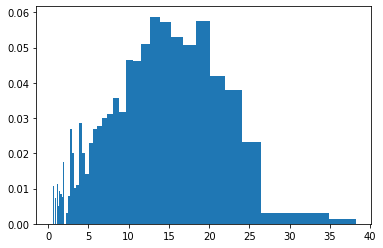

In [96]:
var = (dat['Δt'])[pts]
# var = var[np.isfinite(var)]
plt.hist(var,np.geomspace(var.min(),var.max()),density=True);

<ipython-input-95-d3910cc616cd>:1: RuntimeWarning: divide by zero encountered in divide
  var = np.abs(dat['μ'][:,0]/dat['μ'][:,1])[pts]
<ipython-input-95-d3910cc616cd>:1: RuntimeWarning: overflow encountered in divide
  var = np.abs(dat['μ'][:,0]/dat['μ'][:,1])[pts]
<ipython-input-95-d3910cc616cd>:1: RuntimeWarning: invalid value encountered in divide
  var = np.abs(dat['μ'][:,0]/dat['μ'][:,1])[pts]


(1601,)


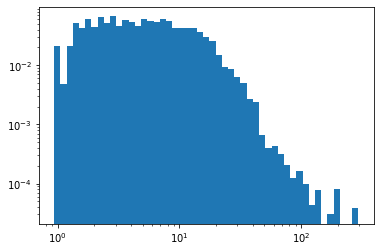

In [95]:
var = np.abs(dat['μ'][:,0]/dat['μ'][:,1])[pts]
# print(var.shape)
# var = var[np.isfinite(var)
print(var.shape)
plt.hist(var,np.geomspace(var.min(),var.max()),density=True);
plt.xscale('log')
plt.yscale('log')

<ipython-input-110-870a5886e211>:2: RuntimeWarning: divide by zero encountered in divide
  var2 = abs(dat['μ'][:,0]/dat['μ'][:,1])
<ipython-input-110-870a5886e211>:2: RuntimeWarning: overflow encountered in divide
  var2 = abs(dat['μ'][:,0]/dat['μ'][:,1])
<ipython-input-110-870a5886e211>:2: RuntimeWarning: invalid value encountered in divide
  var2 = abs(dat['μ'][:,0]/dat['μ'][:,1])
<ipython-input-110-870a5886e211>:3: RuntimeWarning: divide by zero encountered in divide
  var2 = np.where(var2>1,1/var2,var2)


Text(0, 0.5, '$|\\mu_1/\\mu_2|$')

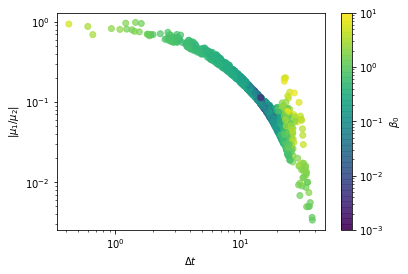

In [110]:
var1 = abs(dat['Δt'])
var2 = abs(dat['μ'][:,0]/dat['μ'][:,1])
var2 = np.where(var2>1,1/var2,var2)
var3 = (abs(dat['β'][:,1]))[pts]

scat = plt.scatter(var1[pts],var2[pts],c=var3,norm=colors.LogNorm(vmin=1e-3, vmax=10),alpha=0.7);
plt.colorbar(scat,label=r'$\beta_0$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'$|\mu_1/\mu_2|$')

Text(0.5, 0, '$\\beta_{\\rm min}$')

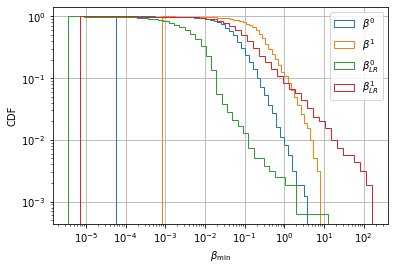

In [111]:
for var, lab in zip([dat['β'][:,0],dat['β'][:,1], dat['βLR'][:,0], dat['βLR'][:,1]], [r'$\beta^0$',r'$\beta^1$', r'$\beta^0_{LR}$',r'$\beta^1_{LR}$']):
    var = np.abs(var[pts])
    var = var[np.isfinite(var)]

    plt.hist(var,np.geomspace(var[var>0].min(),var.max()),alpha=1,density=True,label=lab,histtype='step',cumulative=-1)
    
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend();
plt.ylabel(r'CDF')
plt.xlabel(r'$\beta_{\rm min}$')
# plt.xlim(1e-4,None)

<ipython-input-113-a6347ed8f0d0>:1: RuntimeWarning: divide by zero encountered in divide
  Asqrt=np.abs((dat['μ'][:,0]/dat['μ'][:,1])[pts])**0.5
<ipython-input-113-a6347ed8f0d0>:1: RuntimeWarning: overflow encountered in divide
  Asqrt=np.abs((dat['μ'][:,0]/dat['μ'][:,1])[pts])**0.5
<ipython-input-113-a6347ed8f0d0>:1: RuntimeWarning: invalid value encountered in divide
  Asqrt=np.abs((dat['μ'][:,0]/dat['μ'][:,1])[pts])**0.5


Text(0, 0.5, '$r$')

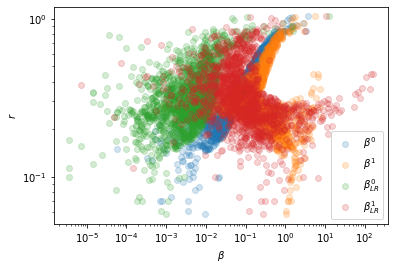

In [113]:
Asqrt=np.abs((dat['μ'][:,0]/dat['μ'][:,1])[pts])**0.5

for i,(var, lab) in enumerate(zip([dat['β'][:,0],dat['β'][:,1], dat['βLR'][:,0], dat['βLR'][:,1]], [r'$\beta^0$',r'$\beta^1$', r'$\beta^0_{LR}$',r'$\beta^1_{LR}$'])):
    var = np.abs(var[pts])
    var = var[np.isfinite(var)]

    plt.scatter(var,1/Asqrt,label=lab,alpha=0.2)
    
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$r$')

### Find degeneracies in GO

Find trajectories so $\mu_1/\mu_2$ is within 1/SNR but $GM_1\Delta t = GM_2\Delta t$

**Note** It requires changing the source distance

Text(0.5, 0, '$\\sqrt{r}$')

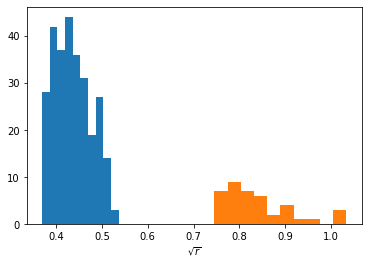

In [39]:
dts = dat['Δt'][pts]
rs = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5

cond1 = np.abs(dts-10)<2
plt.hist(rs[cond1])

cond2 = (np.abs(dts-1)<2)
plt.hist(rs[cond2])

plt.xlabel(r'$\sqrt{r}$')


### Find trajectories where the first image is observable, but the second isn't 

We assum $\frac{dN}{d\rho}\propto \rho^{-2}$ (homogeneous in volume), with a total number of events above $\rho_{\rm th}=8$

As a function of $\rho$, we want to look at the fraction of events where:
* $\sqrt{|\mu_i|}\rho>\rho_{\rm th}$ image i detectable
* $(1-\mathcal{M}(\beta_i))\sqrt{|\mu_i|}\rho >\rho_{\rm th}$ image i detected w/o GSHE
* $\mathcal{M}(\beta_i)\sqrt{|\mu_i|}\rho>1$ GSHE detectable
* $\Delta t<1$s signals overlap

**Ideas**
* plot in terms of the deflection angle $\alpha$, such that $\cos(\alpha) = - \sum_i \hat x_{i,\rm src}\hat x_{i,\rm obs}$ (**check**).
* additional dependence in $\cos(\theta_{\rm src})-\cos(\theta_{\rm obs})$, characterizes the deflection relative to the spin.

In [10]:
bt_fid = 0.1
M = 20

rho_th = 8

mism, SNR = fc.mismatch_gshe(M,bt_fid=bt_fid)
# bt_lim = bt_fid/
print(mism,SNR,mism*SNR**2)

/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:143: RuntimeWarning: divide by zero encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:143: RuntimeWarning: invalid value encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:143: RuntimeWarning: invalid value encountered in exp
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))


0.0020236005993766737 23.87348196753965 1.1533372822531107


/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:143: RuntimeWarning: divide by zero encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:143: RuntimeWarning: invalid value encountered in divide
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
/home/miguel/code/GSHE/scripts/../GSHEWaveform/forecast.py:143: RuntimeWarning: invalid value encountered in exp
  F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))


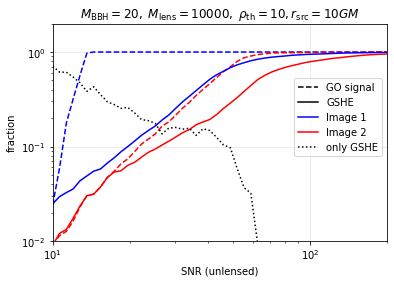

In [47]:
bt_fid = 0.1
Mbbh = 20
Mlens = 1e4
rho_th = 10

rhos = np.geomspace(rho_th,200)

M0, SNR = fc.mismatch_gshe(Mbbh,bt_fid=bt_fid,M_fid=Mlens)


N_tot = len(dat['Δt'][pts])

mag1 = np.abs(dat['μ'][:,0][pts])
mag2 = np.abs(dat['μ'][:,1][pts])

Miss1 = M0*np.abs(dat['β'][:,0][pts]/bt_fid)
Miss2= M0*np.abs(dat['β'][:,1][pts]/bt_fid)

# #first image detectable
Det_1 = np.array([np.sum(rho*mag1**0.5>rho_th) for rho in rhos])
# plt.plot(rhos,Det_1/N_tot,'b:')

# #second image detectable
Det_2 = np.array([np.sum(rho*mag2**0.5>rho_th) for rho in rhos])
# plt.plot(rhos,Det_2/N_tot,'r:')

#first image detected
DetM_1 = np.array([np.sum(rho*mag1**0.5*np.sqrt(1-Miss1)>rho_th) for rho in rhos])
plt.plot(rhos,DetM_1/N_tot,'b--')

#second image detected
DetM_2 = np.array([np.sum(rho*mag2**0.5*np.sqrt(1-Miss2)>rho_th) for rho in rhos])
plt.plot(rhos,DetM_2/N_tot,'r--')


#GSHE detectable
GSHE_1 = np.array([np.sum((rho*mag1**0.5*(Miss1)**0.5>1)&(rho*mag1**0.5>rho_th)) for rho in rhos])
plt.plot(rhos,GSHE_1/N_tot,'b-')

#GSHE detectable
GSHE_2 = np.array([np.sum((rho*mag2**0.5*(Miss2)**0.5>1)&(rho*mag2**0.5>rho_th)) for rho in rhos])
plt.plot(rhos,GSHE_2/N_tot,'r-')



plt.plot([],'k--',label='GO signal')
plt.plot([],'k-',label='GSHE')
plt.plot([],'b-',label='Image 1')
plt.plot([],'r-',label='Image 2')


#miss 2 entirely, but detect 1
only1 = np.array([np.sum((rho*mag1**0.5*Miss1**0.5>1) & (rho*mag2**0.5*np.sqrt(1-Miss2)<rho_th)) for rho in rhos])

plt.plot(rhos,only1/GSHE_1,'k:',label='only GSHE')

# GO = np.array([np.sum((rho*mag1**0.5*np.sqrt(1-Miss1)>rho_th) & (rho*mag2**0.5*np.sqrt(1-Miss2)>rho_th)) for rho in rhos])

# plt.plot(rhos,GO/N_tot,'k-.',label='GO')

plt.legend(loc='center right',ncol=1,bbox_to_anchor=(0.1, 0.12, 0.9, 0.9))

plt.title(r'$M_{\rm BBH}=%g,\; M_{\rm lens} = %g,\;\rho_{\rm th}=%g, r_{\rm src} = 10GM$'%(Mbbh,(Mlens),rho_th))

plt.xlabel('SNR (unlensed)')
plt.ylabel('fraction')


plt.yscale('log');
plt.xscale('log')
plt.grid(alpha=.3)


plt.xlim(rhos.min(),rhos.max())
plt.ylim(1e-2,2)

plt.savefig('../plots/GSHE_detections_vs_SNR.pdf',bbox_inches='tight')
plt.savefig('../plots/GSHE_detections_vs_SNR.png',bbox_inches='tight')

# plt.legend(ncol=3)

In [62]:
bt_fid = 0.1
Mbbh = 20
Mlens = 1e4
rho_th = 10

N_tot = len(dat['Δt'][pts])

for Mlens in [1e4,5e4,1e5]:
    print('M_lens = %.1e'%Mlens,'N(Δt>1s)/Ntot =',(dat['Δt'][pts]*Mlens*1e-5>1).sum()/N_tot)

M_lens = 1.0e+04 N(Δt>1s)/Ntot = 0.7891566265060241
M_lens = 5.0e+04 N(Δt>1s)/Ntot = 0.9891566265060241
M_lens = 1.0e+05 N(Δt>1s)/Ntot = 0.9975903614457832


0.09517759989983551 1660
0.02559402748333137


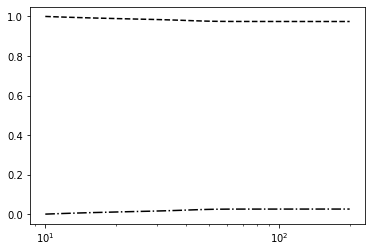

In [12]:
from scipy.integrate import cumtrapz

dNdrho = 1/rhos**2
norm = cumtrapz(dNdrho,rhos,initial=0)[-1]

print(norm,N_tot)

cum1 = cumtrapz(only1*dNdrho,rhos,initial=0)

plt.semilogx(rhos,cum1/norm/N_tot,'k-.',label='only GSHE')
plt.plot(rhos,1-cum1/norm/N_tot,'k--',label='only GSHE')

print(cum1[-1]/norm/N_tot)

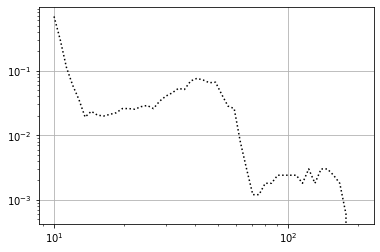

In [13]:
plt.loglog(rhos,only1/Det_1,'k:')
plt.grid()

[[   4]
 [   6]
 [  11]
 [  14]
 [  21]
 [  25]
 [  29]
 [  34]
 [  35]
 [  42]
 [  47]
 [  48]
 [  49]
 [  51]
 [  56]
 [  62]
 [  63]
 [  76]
 [  77]
 [  78]
 [  79]
 [  81]
 [  87]
 [  92]
 [  95]
 [  96]
 [ 102]
 [ 105]
 [ 107]
 [ 112]
 [ 114]
 [ 119]
 [ 121]
 [ 130]
 [ 131]
 [ 138]
 [ 149]
 [ 152]
 [ 153]
 [ 154]
 [ 167]
 [ 168]
 [ 170]
 [ 171]
 [ 172]
 [ 183]
 [ 186]
 [ 187]
 [ 191]
 [ 195]
 [ 202]
 [ 204]
 [ 208]
 [ 211]
 [ 216]
 [ 217]
 [ 219]
 [ 223]
 [ 231]
 [ 232]
 [ 235]
 [ 238]
 [ 248]
 [ 252]
 [ 253]
 [ 256]
 [ 260]
 [ 265]
 [ 277]
 [ 281]
 [ 286]
 [ 290]
 [ 293]
 [ 300]
 [ 304]
 [ 306]
 [ 311]
 [ 324]
 [ 325]
 [ 327]
 [ 338]
 [ 347]
 [ 352]
 [ 353]
 [ 355]
 [ 359]
 [ 360]
 [ 364]
 [ 371]
 [ 372]
 [ 377]
 [ 384]
 [ 385]
 [ 389]
 [ 390]
 [ 393]
 [ 402]
 [ 411]
 [ 412]
 [ 413]
 [ 426]
 [ 436]
 [ 441]
 [ 444]
 [ 451]
 [ 455]
 [ 465]
 [ 470]
 [ 478]
 [ 483]
 [ 504]
 [ 506]
 [ 507]
 [ 519]
 [ 522]
 [ 524]
 [ 527]
 [ 528]
 [ 531]
 [ 534]
 [ 547]
 [ 556]
 [ 558]
 [ 567]
 [ 568]


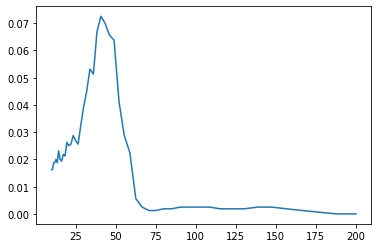

In [288]:
#miss 2 entirely, but detect 1
only1 = np.array([np.sum((rho*mag1**0.5*Miss1**0.5>1) & (rho*mag2**0.5<rho_th)) for rho in rhos])
dtcut = np.argwhere(dat['Δt'][pts]<10)
plt.plot(rhos,only1/N_tot)
print(dtcut)

Text(0.5, 0, 'Mismatch')

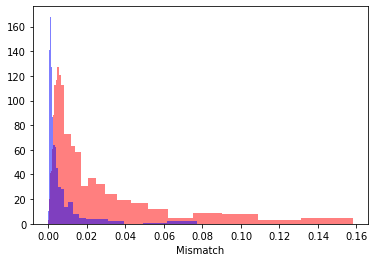

In [260]:
plt.hist(Miss2,np.geomspace(Miss2.min(),Miss2.max()),color='r',alpha=.5);
plt.hist(Miss1,np.geomspace(Miss1.min(),Miss1.max()),color='b',alpha=.5);
plt.xlabel('Mismatch')

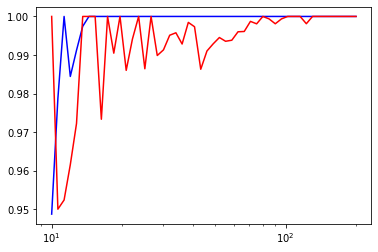

In [263]:
plt.plot(rhos,DetM_1/Det_1,'b-',label='Image 1 detected/detectable')
plt.plot(rhos,DetM_2/Det_2,'r-',label='Image 1 detected/detectable')
plt.xscale('log')

### Explore relationships between trajectories

In [100]:
cosA = -((np.cos(dat['ϕ_obs'])*np.cos(dat['ϕ_src']) + np.sin(dat['ϕ_obs'])*np.sin(dat['ϕ_src'])
         )*np.sin(dat['θ_obs'])*np.sin(dat['θ_src'])
         +np.cos(dat['θ_obs'])*np.cos(dat['θ_src']))

alpha=np.arccos(cosA)

dz = np.cos(dat['θ_obs']) - np.cos(dat['θ_src'])

In [101]:
alpha.shape, dz.shape

((4155,), (4155,))

Text(0, 0.5, '$\\sqrt{\\mu_1/\\mu_2|}$')

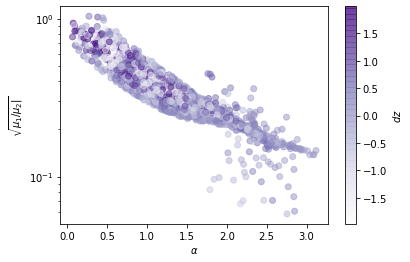

In [108]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
alphax = alpha[pts]
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['β'][:,0])[pts]
bt1 = np.abs(dat['β'][:,1])[pts]

colvar = dz[pts]
# np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5

scat = plt.scatter(alphax,Asqrt,c=colvar,
                   alpha=0.5,cmap='Purples',
                   norm=colors.Normalize(colvar.min(),colvar.max())) 

plt.colorbar(scat,label=r'$dz$')
# plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.9,20)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\sqrt{\mu_1/\mu_2|}$')

<ipython-input-115-e781de129426>:1: RuntimeWarning: divide by zero encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
<ipython-input-115-e781de129426>:1: RuntimeWarning: overflow encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
<ipython-input-115-e781de129426>:1: RuntimeWarning: invalid value encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
<ipython-input-115-e781de129426>:2: RuntimeWarning: divide by zero encountered in divide
  Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
<ipython-input-115-e781de129426>:2: RuntimeWarning: overflow encountered in divide
  Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
<ipython-input-115-e781de129426>:2: RuntimeWarning: invalid value encountered in divide
  Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
<ipython-input-115-e781de129426>:6: RuntimeWarning: divide by zero encountered in divide
  colvar = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
<ipython-input-115-

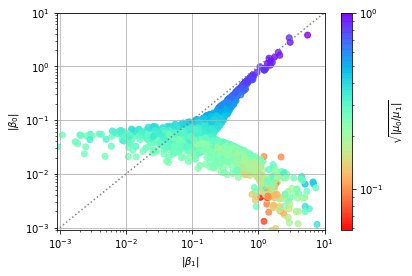

In [115]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['β'][:,0])[pts]
bt1 = np.abs(dat['β'][:,1])[pts]

colvar = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5

scat = plt.scatter(bt1,bt0,c=colvar,
                   alpha=0.8,cmap='rainbow_r',
                   norm=colors.LogNorm(colvar.min(),1)) 
#,norm=colors.LogNorm(colvar.min(),colvar.max()))
plt.colorbar(scat,label=r'$\sqrt{|\mu_0/\mu_1|}$')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.9,20)
plt.xlabel(r'$|\beta_1|$')
plt.ylabel(r'$|\beta_0|$')
bt = np.geomspace(1e-3,10)
plt.xlim(.9e-3,10)
plt.ylim(.9e-3,10)
plt.plot(bt,bt,c='gray',ls=':')
plt.grid()

<ipython-input-117-b7153dfb9d12>:1: RuntimeWarning: divide by zero encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
<ipython-input-117-b7153dfb9d12>:1: RuntimeWarning: overflow encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
<ipython-input-117-b7153dfb9d12>:1: RuntimeWarning: invalid value encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
<ipython-input-117-b7153dfb9d12>:2: RuntimeWarning: divide by zero encountered in divide
  Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
<ipython-input-117-b7153dfb9d12>:2: RuntimeWarning: overflow encountered in divide
  Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
<ipython-input-117-b7153dfb9d12>:2: RuntimeWarning: invalid value encountered in divide
  Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5


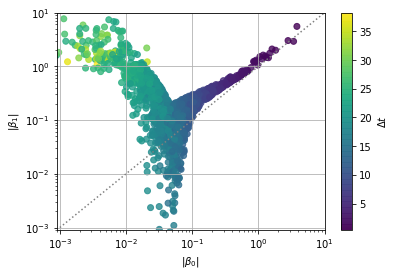

In [117]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['β'][:,0])[pts]
bt1 = np.abs(dat['β'][:,1])[pts]

colvar = dat['Δt'][pts]

scat = plt.scatter(bt0,bt1,c=colvar,alpha=0.8) #,norm=colors.LogNorm(colvar.min(),colvar.max()))
plt.colorbar(scat,label=r'$\Delta t$')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.9,20)
plt.xlabel(r'$|\beta_0|$')
plt.ylabel(r'$|\beta_1|$')
bt = np.geomspace(1e-3,10)
plt.xlim(.9e-3,10)
plt.ylim(.9e-3,10)
plt.plot(bt,bt,c='gray',ls=':')
plt.grid()

In [ ]:
print('Fraction of trajectories with beta0>beta1')

<ipython-input-153-244da4bc667f>:20: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(sct1,label=r'$\Delta t [2GM]$',cmap='Grays')


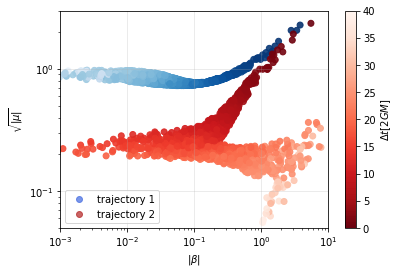

In [153]:
# cvar = np.abs(np.concatenate(dat['β'][:,0][pts],dat['β'][:,1][pts]))
cnorm = colors.Normalize(0,40) #dat['Δt'][pts].max() #colors.LogNorm(0.1,50)

sct0 = plt.scatter(np.abs(dat['β'][:,0][pts]),dat['μ'][:,0][pts]**0.5,
                   c=np.abs(dat['Δt'][pts]),
                   cmap='Blues_r', alpha=0.9,
                   norm=cnorm)

sct1 = plt.scatter(np.abs(dat['β'][:,1][pts]),np.abs(dat['μ'][:,1][pts])**0.5,
                   c=np.abs(dat['Δt'][pts]),
                   cmap='Reds_r', alpha=0.9,
                   norm=cnorm)

# sctx = plt.scatter([],[],cmap='Grays', 
#                    norm=cnorm)
plt.scatter([],[],c='royalblue',alpha=.7,label='trajectory 1')
plt.scatter([],[],c='firebrick',alpha=.7,label='trajectory 2')

plt.legend(loc='lower left')
plt.colorbar(sct1,label=r'$\Delta t [2GM]$',cmap='Grays')
plt.xlim(1e-3,10)
plt.ylim(5e-2,3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$|\beta|$')
plt.ylabel(r'$\sqrt{|\mu|}$')
plt.grid(alpha=.3)
plt.savefig('../plots/GSHE_trajectories.pdf',bbox_inches='tight')

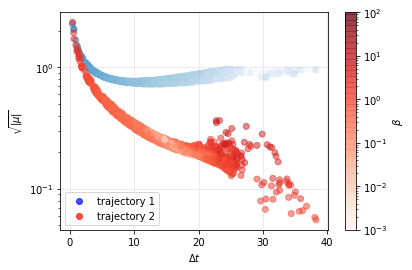

In [126]:
# cvar = np.abs(np.concatenate(dat['β'][:,0][pts],dat['β'][:,1][pts]))
cnorm = colors.LogNorm(1e-3,100)

sct0 = plt.scatter(dat['Δt'][pts],dat['μ'][:,0][pts]**0.5,
                   c=np.abs(dat['β'][:,0][pts]),
                   cmap='Blues', alpha=0.5,
                   norm=cnorm)

sct1 = plt.scatter(dat['Δt'][pts],np.abs(dat['μ'][:,1][pts])**0.5,
                   c=np.abs(dat['β'][:,1][pts]),
                   cmap='Reds',alpha=0.5,
                   norm=cnorm)

# sctx = plt.scatter([],[],cmap='Grays', 
#                    norm=cnorm)
plt.scatter([],[],c='blue',alpha=.7,label='trajectory 1')
plt.scatter([],[],c='red',alpha=.7,label='trajectory 2')

plt.legend(loc='lower left')
plt.colorbar(sct1,label=r'$\beta$')
plt.yscale('log')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'$\sqrt{|\mu|}$')
plt.grid(alpha=.3)

<ipython-input-154-56e0d823f7f8>:1: RuntimeWarning: divide by zero encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
<ipython-input-154-56e0d823f7f8>:1: RuntimeWarning: overflow encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
<ipython-input-154-56e0d823f7f8>:1: RuntimeWarning: invalid value encountered in divide
  var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]


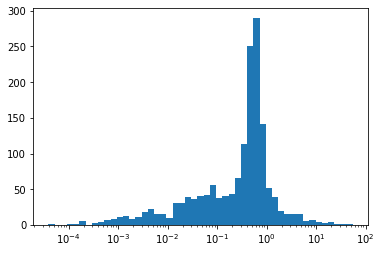

In [154]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
plt.hist(var,np.geomspace(var.min(),var.max()))
plt.xscale('log')

Text(0, 0.5, '$\\Delta t$')

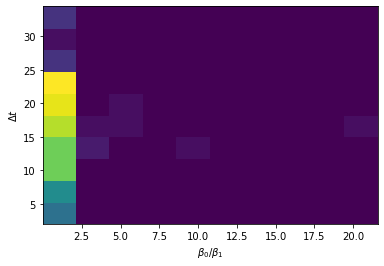

In [628]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
plt.hist2d(var,dat['Δt'][pts],density=True)
# plt.xscale('log')
plt.xlabel(r'$\beta_0/\beta_1$')
plt.ylabel(r'$\Delta t$')

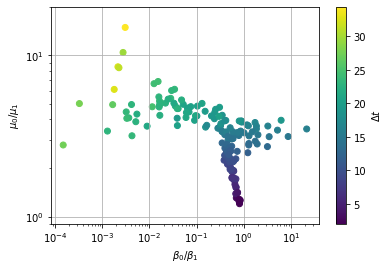

In [644]:
var = np.abs(dat['β'][:,0]/dat['β'][:,1])[pts]
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['β'][:,0])[pts]

colvar = dat['Δt'][pts]
sizevar = 10000*dat['β'][:,0][pts]

scat = plt.scatter(var,1/Asqrt,c=colvar) #,norm=colors.LogNorm(colvar.min(),colvar.max()))
plt.colorbar(scat,label=r'$\Delta t$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.9,20)
plt.xlabel(r'$\beta_0/\beta_1$')
plt.ylabel(r'$\mu_0/\mu_1$')
plt.grid()

### Look at beta_LR

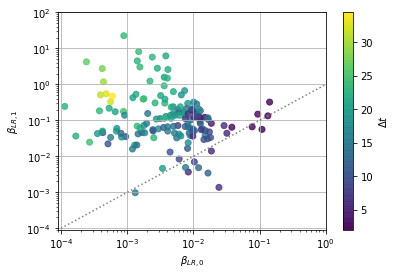

In [664]:
Asqrt = np.abs(dat['μ'][:,1]/dat['μ'][:,0])[pts]**0.5
bt0 = np.abs(dat['βLR'][:,0])[pts]
bt1 = np.abs(dat['βLR'][:,1])[pts]

colvar = dat['Δt'][pts]

scat = plt.scatter(bt0,bt1,c=colvar,alpha=0.8) #,norm=colors.LogNorm(colvar.min(),colvar.max()))
plt.colorbar(scat,label=r'$\Delta t$')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.9,20)
plt.xlabel(r'$\beta_{LR,0}$')
plt.ylabel(r'$\beta_{LR,1}$')
bt = np.geomspace(1e-4,10)
plt.xlim(.9e-4,1)
plt.ylim(.9e-4,100)
plt.plot(bt,bt,c='gray',ls=':')
plt.grid()